# Random Forest Training for QSO targets selection

**Author:** Edmond Chaussidon (CEA Saclay) (contact: edmond.chaussidon@cea.fr)

This notebook explains how the random forest files (for the targets selection) are generated. To have a brief overview of the QSO targets selection and an interpretability of this selection, see `qso-dr8.ipynb` notebook written for DR8s release (however no major changes are expected with DR9 !)

All the file are written and saved in NERSC : `/global/cfs/cdirs/desi/target/analysis/RF`

**/!\** **WARNING** This notebook had generated files in NERSC !! **PLEASE** change path and savename to don't overwritte data or be sure to keep alive the current files. **/!\**

The training is divided in three parts :
    
    * 1) data_collection : collect data from dr9 (match sdss with dr9)
    * 2) data_preparation : build atributes for RF
    * 3) train_test_RF : training and some tests

**Remark:** The first part is time consumming and already saved in : `/global/cfs/cdirs/desi/target/analysis/RF/`

**UPDATE:** We add quasars from VI in the training!


In [ ]:
DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

from pathlib import Path
path_train = f'{Path().absolute()}/../../py/desitarget/train/'

-------
## 1.1)  data_collection

**WARNING:** This part is time consuming...

**REMARK:** Not necessary to run this section for the training if the files are existing in DIR **/!\** 

In [ ]:
from desitarget.train.data_collection.sweep_meta import sweep_meta

sweep_meta('dr9s', f'{DIR}dr9s_sweep_meta.fits')
sweep_meta('dr9n', f'{DIR}dr9n_sweep_meta.fits')

* Add your version of topcat in my_tractor_extract_batch.py :

    `STILTSCMD = 'java -jar -Xmx4096M /global/homes/e/edmondc/Software/topcat/topcat-full.jar -stilts'`
    
* If you want a version of topcat go [here](`http://www.star.bris.ac.uk/~mbt/topcat/`).


In [ ]:
#from desitarget.train.data_collection.my_tractor_extract_batch import my_tractor_extract_batch

#collect QSO sample
#my_tractor_extract_batch(16, f'{DIR}QSO_DR9s_sdss.fits', 'dr9s', '0,360,-10,30', 'qso', path_train, DIR)

In [ ]:
#collect stars sample
#my_tractor_extract_batch(4, f'{DIR}STARS_DR9s.fits', 'dr9s', '320,345,-1.25,1.25', 'stars', path_train, DIR)

In [ ]:
#collect test sample 
#my_tractor_extract_batch(4, f'{DIR}TEST_DR9s.fits', 'dr9s', '30,45,-5,5', 'test', path_train, DIR)

## 1.2) Add QSOs from VI

    * We match VI quasars with DR9 photometry
    * We add ALL quasars on the catalog (don't check if they are in the test zone --> they will be removed in the next step!)
    * We add VI quasars which are in the test zone into the Test file

In [ ]:
from desitarget.train.data_collection.QSOs_from_VI import extract_qsos_from_vi, sdss_vi_merger

DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

vi_catalog_list = [f'{DIR}QSO_cascade_V1.fits']
output_path = f'{DIR}QSO_DR9s_VI.fits'

extract_qsos_from_vi(vi_catalog_list, output_path)

In [ ]:
from desitarget.train.data_collection.QSOs_from_VI import sdss_vi_merger

file_sdss = f'{DIR}QSO_DR9s_SDSS.fits'
file_VI = f'{DIR}QSO_DR9s_VI.fits'

output = f'{DIR}QSO_DR9s.fits'

test_zones = [[30, 45, -5, 5], [80, 90, -25, -15]]

sdss_vi_merger(file_sdss, file_VI, output, test_zones)

In [ ]:
from desitarget.train.data_collection.QSOs_from_VI import add_qso_vi_test

file_test = f'{DIR}TEST_DR9s.fits'
file_VI = f'{DIR}QSO_DR9s_VI.fits'

output = f'{DIR}TEST_DR9s_final.fits'

test_zones = [[30, 45, -5, 5], [80, 90, -25, -15]]

add_qso_vi_test(file_test, file_VI, output, test_zones)

--------
## 2) data_preparation 

**Remark :** We remove test region from training data in *data_preparation/Code/make_training_samples.py* (it is **hard coding**)  for the region 30<RA<45 & -5<DEC<5. 

**/!\** **Take CARE** if you don't use this region for the test_sample **/!\**

In [ ]:
DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

from desitarget.train.data_preparation.make_training_samples import make_training_samples

#range in r mag for the training and test sample : 17.5 <--> max_rmag
max_rmag = 23.2

# Need to find a balance between acceptable errors in the measured data and good representativeness of the photometric scattering inherent to QSO.
# (cf mail exchange with Christophe and Nathalie)
# Ratio = QSO_data.FLUX_R * np.sqrt(QSO_data.FLUX_IVAR_R)
# 0.2 ==> ratio=5 | 0.1 ==> ratio=10 | 0.02 ==> ratio=50
QSO_MAX_MAG_ERR_LEVEL = 0.1

#changer nom qso sample for training
make_training_samples(f'{DIR}QSO_DR9s.fits', f'{DIR}STARS_DR9s.fits', f'{DIR}QSO_TrainingSample_DR9s.fits', f'{DIR}STARS_TrainingSample_DR9s.fits', f'{DIR}STARS_TrainingSample_Highz_DR9s.fits', max_rmag, QSO_MAX_MAG_ERR_LEVEL)

In [ ]:
from desitarget.train.data_preparation.make_test_sample import make_test_sample

#un peu long
make_test_sample(f'{DIR}TEST_DR9s_final.fits', f'{DIR}TestSample_DR9s.fits', max_rmag=23.0)

------
## 3) train_test_RF


In [ ]:
from pathlib import Path
path_train = f'{Path().absolute()}/../../py/desitarget/train/'

DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

max_rmag = 23.2

print("[WARNING] DO 2 BEFORE 3 !!!")

In [ ]:
#Pipeline Congifuration (to generate RF with different hyperparameters)
from desitarget.train.train_test_RF.PipelineConfigScript import PipelineConfigScript

fpn_STARS_TrainingSample = f"{DIR}STARS_TrainingSample_DR9s.fits"
fpn_STARS_TrainingSample_Highz = f"{DIR}STARS_TrainingSample_Highz_DR9s.fits"
fpn_QSO_TrainingSample = f"{DIR}QSO_TrainingSample_DR9s.fits"
fpn_TestSample = f"{DIR}TestSample_DR9s.fits"
fpn_QLF = f"{path_train}data_preparation/ROSS4_tabR"

suffixe = '_final_ratio10'
fpn_config = f"{DIR}config{suffixe}.npz"

PipelineConfigScript(fpn_QSO_TrainingSample, fpn_STARS_TrainingSample, fpn_STARS_TrainingSample_Highz, fpn_TestSample, fpn_QLF, fpn_config, max_rmag=max_rmag, suffixe=suffixe)

In [ ]:
#Random Forest training
from desitarget.train.train_test_RF.train_RF import train_RF

#RF all-z training
train_RF(f'{DIR}config{suffixe}.npz', 'DR9s_LOW', f'{DIR}RFmodel/DR9s_LOW')

In [ ]:
#RF Highz training
train_RF(f'{DIR}config{suffixe}.npz', 'DR9s_HighZ', f'{DIR}RFmodel/DR9s_HighZ')

In [ ]:
#Sklearn to desitarget format
from desitarget.train.train_test_RF.Convert_to_DESI_RF import convert_and_save_to_desi 

RF_filename_input = f"{DIR}RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz"
RF_filename_output = f"{DIR}RFmodel_desitarget/rf_model_dr9{suffixe}.npz"
convert_and_save_to_desi(RF_filename_input, RF_filename_output)

RF_HighZ_filename_input = f"{DIR}RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz"
RF_HighZ_filename_output = f"{DIR}RFmodel_desitarget/rf_model_dr9_HighZ{suffixe}.npz"
convert_and_save_to_desi(RF_HighZ_filename_input, RF_HighZ_filename_output)

------------
## 4) Some tests 

    * Plot for completeness, importance feature ect ...
    * enable also to tune the threshold selection :) 

In [ ]:
#plot only for one training

from desitarget.train.train_test_RF.Some_tests import make_some_tests_and_plots

suffixe = '_final_ratio10'

inputFile = f'{DIR}TestSample_DR9s.fits'
RF_file = f'{DIR}RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
RF_Highz_file = f'{DIR}RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'

make_some_tests_and_plots(inputFile, RF_file, RF_Highz_file, rmax=23.0)


############################################
Input file =  /global/cfs/cdirs/desi/target/analysis/RF/TestSample_DR9s_old.fits
Original size:  3135690
Reduce size:  535391
############################################

Load Random Forest: 
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio10.pkl.gz
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio10.pkl.gz
Random Forest over:  535391  objects

Load Random Forest: 
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio10_Wcut.pkl.gz
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio10_Wcut.pkl.gz
Random Forest over:  535391  objects

############################################
R magnitude Elements from Tes

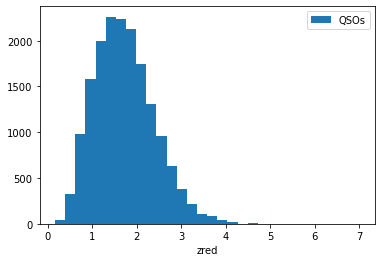


[INFO] CUT1 :  cut = 0.8 - 0.05*np.tanh(r - 20.5) & cut_Highz = 1.0


############################################
density dr9 =  305.43443606796154  deg^-2 completeness dr9 0.9818309694056969
density dr9 Highz =  0.0  deg^-2 completeness dr9 Highz 0.0
density dr9 Total =  305.43443606796154  deg^-2 completeness dr9 Total 0.9818309694056969
############################################


[INFO] CUT2 :  cut = 0.7 - 0.05*np.tanh(r - 20.5) & cut_Highz = 1.0


############################################
density dr9 =  307.8811115680585  deg^-2 completeness dr9 0.9800140663462665
density dr9 Highz =  0.0  deg^-2 completeness dr9 Highz 0.0
density dr9 Total =  307.8811115680585  deg^-2 completeness dr9 Total 0.9800140663462665
############################################



/global/homes/e/edmondc/Software/desitarget/py/desitarget/train/train_test_RF/Some_tests.py:201: RuntimeWarning: invalid value encountered in true_divide
  ratio = y/x
/global/homes/e/edmondc/Software/desitarget/py/desitarget/train/train_test_RF/Some_tests.py:204: RuntimeWarning: invalid value encountered in true_divide
  errors = np.sqrt(y*(x-y)/x**3)


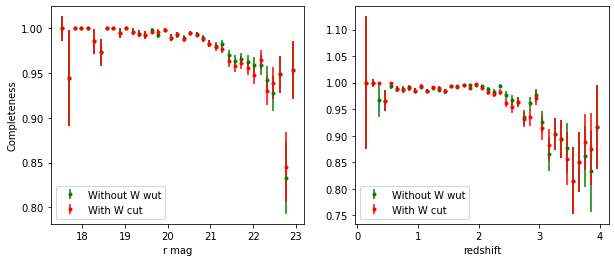

In [1]:
#plot to compare two differents training

from desitarget.train.train_test_RF.Some_tests import make_some_tests_and_plots_2_training

DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

inputFile = f'{DIR}TestSample_DR9s_old.fits'

suffixe = '_final_ratio10'
RF_file = f'{DIR}RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
RF_Highz_file = f'{DIR}RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
#ut = [0.74, 0.05, 22.5, 0.95]
cut = [0.8, 0.05, 20.5, 1.0]

suffixe = '_final_ratio10_Wcut'
RF_file_2 = f'{DIR}RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
RF_Highz_file_2 = f'{DIR}RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
cut2 = [0.70, 0.05, 20.5, 1.0]

make_some_tests_and_plots_2_training(inputFile, RF_file, RF_Highz_file, RF_file_2, RF_Highz_file_2, cut, cut2, r_mag_max_sel=23.0, surface_vi=False, save=False, label1='Without W wut', label2='With W cut')

In [ ]:
#plot to compare to desitarget

from desitarget.train.train_test_RF.Some_tests import new_training_versus_desitarget

DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

suffixe = '_final_ratio10'

inputFile = f'{DIR}TestSample_DR9s_old.fits'

RF_file = f'{DIR}RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
RF_Highz_file = f'{DIR}RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'

cut = [0.70, 0.05, 20.5, 1.0]

new_training_versus_desitarget(inputFile, RF_file, RF_Highz_file, cut=cut, r_mag_max_sel=23.0, surface_vi=False)

--------------

## FREE SPACE :

--------------

We derive here the cut from a tmp targets selection done with weak cuts

In [1]:
import numpy as np
import fitsio
import healpy as hp
import matplotlib.pyplot as plt

from plot import plot_cart, plot_moll

from desitarget.myRF import myRF
from desitarget.cuts import shift_photo_north
from desitarget.geomask import hp_in_box
from pkg_resources import resource_filename

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/global/homes/e/edmondc/Software/desi_ec/ec_style.mplstyle')

#Y a une fonction dans desiarget pour le faire mais ok on perd pas de temps
pathToRF = '/global/homes/e/edmondc/Software/desitarget/py/desitarget/data'

# number of variables
nfeatures = 11

#------------------------------------------------------------------------------#
# Usefull fonction

def magsExtFromFlux(dataArray, show=False):
    gflux  = dataArray['FLUX_G'][:]/dataArray['MW_TRANSMISSION_G'][:]
    rflux  = dataArray['FLUX_R'][:]/dataArray['MW_TRANSMISSION_R'][:]
    zflux  = dataArray['FLUX_Z'][:]/dataArray['MW_TRANSMISSION_Z'][:]
    W1flux  = dataArray['FLUX_W1'][:]/dataArray['MW_TRANSMISSION_W1'][:]
    W2flux  = dataArray['FLUX_W2'][:]/dataArray['MW_TRANSMISSION_W2'][:]
    
    W1flux[np.isnan(W1flux)]=0.
    W2flux[np.isnan(W2flux)]=0.
    gflux[np.isnan(gflux)]=0.
    rflux[np.isnan(rflux)]=0.
    zflux[np.isnan(zflux)]=0.
    W1flux[np.isinf(W1flux)]=0.
    W2flux[np.isinf(W2flux)]=0.
    gflux[np.isinf(gflux)]=0.
    rflux[np.isinf(rflux)]=0.
    zflux[np.isinf(zflux)]=0.
    
        
    is_north = (dataArray['DEC'][:] >= 32) & (dataArray['RA'][:] >= 60) & (dataArray['RA'][:] <= 310)
    print(f'shift photometry for {is_north.sum()} objects')
    if show:
        plt.figure()
        plt.hist(gflux[is_north], bins=100, range=(0, 50), label='not shifted')
    gflux[is_north], rflux[is_north], zflux[is_north] = shift_photo_north(gflux[is_north], rflux[is_north], zflux[is_north])
    if show:
        plt.hist(gflux[is_north], bins=100, range=(0, 50), label='shifted')
        plt.legend()
        plt.show()

    g=np.where( gflux>0,22.5-2.5*np.log10(gflux), 0.)
    r=np.where( rflux>0,22.5-2.5*np.log10(rflux), 0.)
    z=np.where( zflux>0,22.5-2.5*np.log10(zflux), 0.)
    W1=np.where( W1flux>0, 22.5-2.5*np.log10(W1flux), 0.)
    W2=np.where( W2flux>0, 22.5-2.5*np.log10(W2flux), 0.)

    g[np.isnan(g)]=0.
    g[np.isinf(g)]=0.
    r[np.isnan(r)]=0.
    r[np.isinf(r)]=0.
    z[np.isnan(z)]=0.
    z[np.isinf(z)]=0.
    W1[np.isnan(W1)]=0.
    W1[np.isinf(W1)]=0.
    W2[np.isnan(W2)]=0.
    W2[np.isinf(W2)]=0.
    
    return g, r, z, W1, W2

def colors(nbEntries, nfeatures, g, r, z, W1, W2):
    colors = np.zeros((nbEntries,nfeatures))

    colors[:,0] = g-r
    colors[:,1] = r-z
    colors[:,2] = g-z
    colors[:,3] = g-W1
    colors[:,4] = r-W1
    colors[:,5] = z-W1
    colors[:,6] = g-W2
    colors[:,7] = r-W2
    colors[:,8] = z-W2
    colors[:,9] = W1-W2
    colors[:,10] = r

    return colors

def compute_proba(sample):
    object_g, object_r ,object_z ,object_W1 ,object_W2 = magsExtFromFlux(sample)
    attributes = colors(object_g.size, nfeatures, object_g, object_r, object_z, object_W1, object_W2)

    rf_fileName = pathToRF + f'/rf_model_dr9_final.npz'
   # rf_Highz_fileName = pathToRF + f'/rf_model_dr9_HighZ.npz'

    print('Load Old Random Forest : ')
    print('    * ' + rf_fileName)
   #print('    * ' + rf_Highz_fileName)
    print('Random Forest over : ', len(attributes),' objects\n')

    print('    * start first RF calculation...')
    myrf =  myRF(attributes, pathToRF, numberOfTrees=500, version=2)
    myrf.loadForest(rf_fileName)
    proba_rf = myrf.predict_proba()

    #print('    * start second RF calculation...')
    #myrf_Highz =  myRF(attributes,pathToRF, numberOfTrees=500, version=2)
    #myrf_Highz.loadForest(rf_Highz_fileName)
    #proba_Highz_rf = myrf_Highz.predict_proba()

    return proba_rf#, proba_Highz_rf

def give_footprint(dataArray):
    
    is_north = (dataArray['DEC'][:] >= 32.2) &\
               (dataArray['RA'][:] >= 60) &\
               (dataArray['RA'][:] <= 310)
    
    is_des = (dataArray['NOBS_G'][:] > 4) &\
         (dataArray['NOBS_R'][:] > 4) &\
         (dataArray['NOBS_Z'][:] > 4) &\
         ((dataArray['RA'][:] >= 320) | (dataArray['RA'][:] <= 100)) &\
         (dataArray['DEC'][:] <= 10)
    
    is_south = (dataArray['DEC'][:] < 50) & ~is_des & ~is_north
    
    print(is_north.sum() + is_south.sum() + is_des.sum())
    print(is_north.size)
    
    return is_north, is_south, is_des

def build_pixmap(dataArray, Nside):
    pixmap = np.zeros(hp.nside2npix(Nside))

    ra, dec = dataArray['RA'][:], dataArray['DEC'][:]

    pixels = hp.ang2pix(Nside, ra, dec, nest=True, lonlat=True)
    pix, counts = np.unique(pixels, return_counts=True)
    pixmap[pix] = counts
    
    return pixmap

In [ ]:
Nside = 256

read_temp = fitsio.FITS(f'/global/homes/e/edmondc/Systematics/regressor/Data/photometry_footprint_dr9_{Nside}.fits')[1]
north = read_temp['ISNORTH'][:]

south = read_temp['ISSOUTH'][:] & ~read_temp['ISDES'][:]
#south[hp_in_box(Nside, [0, 360, 32, 90], inclusive=True)] = False
des = read_temp['ISDES'][:]
footprint = north | south | des


#just to check if our footprint works

#north = build_pixmap(data[:][is_north], Nside)
#plot_moll(north/hp.nside2pixarea(Nside, degrees=True), max=500)
#south = build_pixmap(data[:][is_south], Nside)
#plot_moll(south/hp.nside2pixarea(Nside, degrees=True), max=500)
#des = build_pixmap(data[:][is_des], Nside)
#plot_moll(des/hp.nside2pixarea(Nside, degrees=True), max=500)

data = fitsio.FITS('/global/homes/e/edmondc/Scratch/SHARE/total-targets-qso-dr9-final-tmp.fits')[1]

is_north, is_south, is_des = give_footprint(data)

#proba_rf = compute_proba(data)
#np.save('/global/homes/e/edmondc/Scratch/SHARE/proba-tmp.npy', proba_rf)

proba_rf = np.load('/global/homes/e/edmondc/Scratch/SHARE/proba-tmp.npy')
g, r, z, W1, W2 = magsExtFromFlux(data)

pcut = np.zeros(is_north.size)

pcut[is_north] = 0.88 - 0.04*np.tanh(r[is_north] - 20.5)
pcut[is_south] = 0.84 - 0.04*np.tanh(r[is_south] - 20.5)
pcut[is_des] = 0.70 - 0.05*np.tanh(r[is_des] - 20.5)

sel = (proba_rf >= pcut) & (W1 <= 22.3) & (W2 <= 22.3)

print(sel.sum()/sel.size)

In [ ]:
targets = build_pixmap(data[:][sel], Nside)
targets /= hp.nside2pixarea(Nside, degrees=True)
targets[~footprint] = np.NaN

plot_moll(targets, min=0, max=400)
plot_moll(hp.ud_grade(targets, 64, order_in='NESTED'), min=0, max=400)

tt = build_pixmap(data[:][sel & (r > 22.7)], Nside)
tt /= hp.nside2pixarea(Nside, degrees=True)
tt[~footprint] = np.NaN

plot_moll(hp.ud_grade(tt, 64, order_in='NESTED'), max=100)

zone_test_1 = hp_in_box(256, [120, 240, 32.2, 40], inclusive=True)
zone_test_2 = hp_in_box(256, [120, 240, 24, 32.2], inclusive=True)

print(f"NORTH --->  MEAN : {np.nanmean(targets[north])} | MEDIAN = {np.nanmedian(targets[north])}")
print(f"SOUTH --->  MEAN : {np.nanmean(targets[south])} | MEDIAN = {np.nanmedian(targets[south])}")
print(f"DES --->  MEAN : {np.nanmean(targets[des])} | MEDIAN = {np.nanmedian(targets[des])}")

print(f"ZONE_NORTH --->  MEAN : {np.nanmean(targets[zone_test_1])} | MEDIAN = {np.nanmedian(targets[zone_test_1])}")
print(f"ZONE_SOUTH --->  MEAN : {np.nanmean(targets[zone_test_2])} | MEDIAN = {np.nanmedian(targets[zone_test_2])}")

plt.figure(figsize=(8,8))
plt.hist(targets[des], bins=26, range=(100,600), color='red', alpha=0.7, density=True, label='Des')
plt.hist(targets[north], bins=26, range=(100,600), color='blue', alpha=0.7, density=True, label='North')
plt.hist(targets[south], bins=26, range=(100,600), color='green', alpha=0.7, density=True, label='South')
plt.legend()
plt.grid(True, ls=':', alpha=0.8)
#plt.savefig("Res/explore/hist_after_correction.pdf")

In [ ]:
targets_to_save = build_pixmap(data[:][sel], Nside)
#np.save(path, targets_to_save)

#pour les cuts dans regressor
plt.figure()
plt.hist(targets_to_save[footprint], bins=50, range=(0,50))
plt.show()

#data_to_save = data[:][sel]
#fits = fitsio.FITS(path_fits, 'rw')
#fits.write(data_to_save)